# Observing through LSST's passbands 

In this notebook we are going to take the reference spectra from the pysynphot's spectral atlases and make them pass through the LSST's throughput and the simulated atmospheres from the previous notebooks. 

* Dependencies: 
[pysynphot](https://pysynphot.readthedocs.io/en/latest/) 

For the moment, this notebook relies on some classes and methods from pysynphot (mostly to load the spectra provided by it and to compute the product of SEDs and passbands). This will be changed to avoid external dependencies and to make it compatible with [rubin-sim](https://github.com/lsst/rubin_sim) tools 

# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from scipy import integrate
from astropy.io import fits
#import quadpy

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


# Set LSST's parameters 

In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Define general paths 

In [5]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


Define also the spectral types 

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

In [7]:
spectral_types = ['O','B','A','F','G','K','M']

# Select a spectral atlas 

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [8]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [9]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

FileNotFoundError: [Errno 2] No such file or directory: 'spectral_atlases/atlas_pickles.txt'

# Load with pysynphot the spectra from the selected atlas 

In [10]:
sed_list = np.array(atlas_seds['File'])

In [11]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

Let's organise spectra by spectral type 

In [12]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [13]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

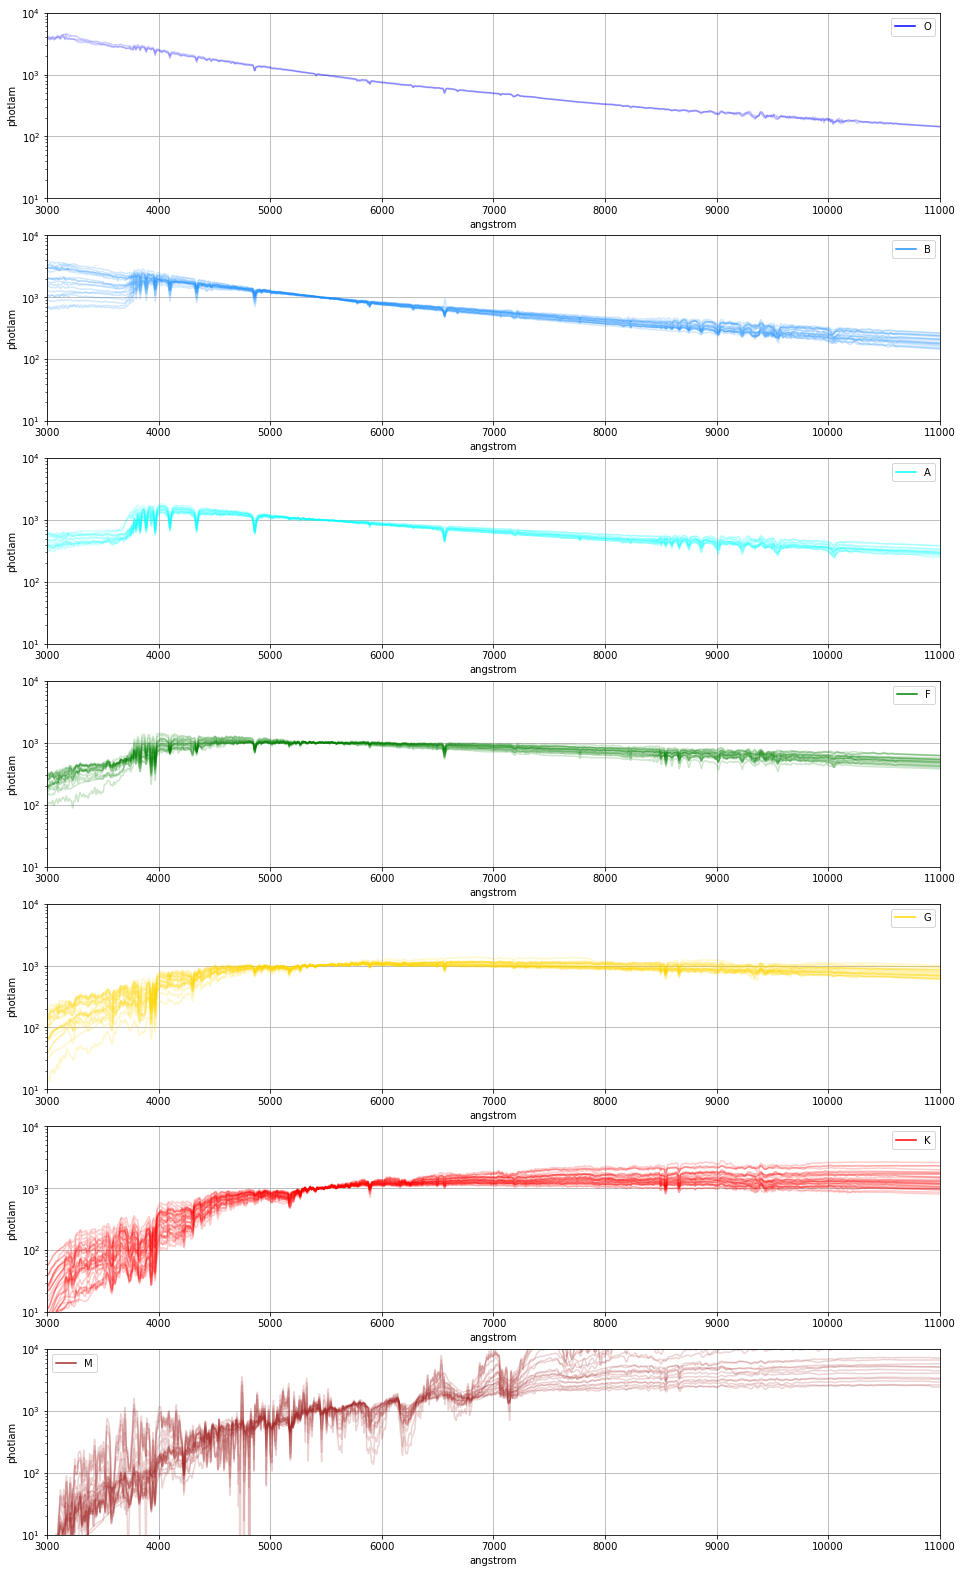

In [15]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(spec.waveunits)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

# Load LSST transmissions file 

In [16]:
datafilename = "data/lsst/old/transmissions-LSST.dat"
df=pd.read_csv(datafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [17]:
wl=df['wl'].values
U=df['U'].values/100.
G=df['G'].values/100.
R=df['R'].values/100.
I=df['I'].values/100.
Z=df['Z'].values/100.
Y4=df['Y4'].values/100.

lsst_bp = []
lsst_bp.append(S.ArrayBandpass(wl*10, U , name="u"))
lsst_bp.append(S.ArrayBandpass(wl*10, G , name="g"))
lsst_bp.append(S.ArrayBandpass(wl*10, R , name="r"))
lsst_bp.append(S.ArrayBandpass(wl*10, I , name="i"))
lsst_bp.append(S.ArrayBandpass(wl*10, Z , name="z"))
lsst_bp.append(S.ArrayBandpass(wl*10, Y4 , name="Y"))

In [18]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

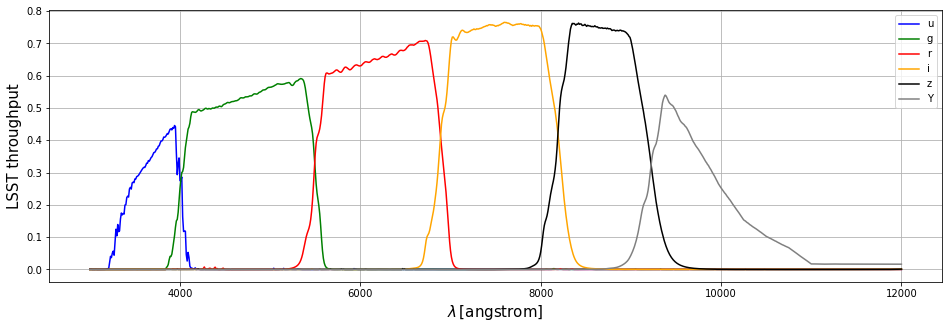

In [19]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

We find a leakage at higher wavelengths for some filters that impacts the colour values of the M type stars 

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
index=1
ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
ax.set_yscale("log")
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

Let's try with a more updated version of the throughputs. We are given only the total passband and the atmosphere that was used to generate them (https://github.com/lsst/throughputs/tree/main/baseline), so in order to have the throughputs we need to divide the passbands by this atmosphere 

In [ ]:
total_passband_path = 'data/lsst/'
total_passband_label = 'total_{0}.dat'
atm_lsst_file = 'atmos_std.dat'

In [ ]:
atm_lsst = np.loadtxt(total_passband_path+atm_lsst_file)

Now, we write the passbands in pysynphot format: 

In [ ]:
wl = atm_lsst[:,0]*10.

lsst_bp_ = []
for f in filters:
    passband_ = np.loadtxt(total_passband_path+total_passband_label.format(f.lower()))
    assert (atm_lsst.shape==passband_.shape)
    throughput_ = passband_[:,1]/atm_lsst[:,1]
    lsst_bp_.append(S.ArrayBandpass(wl, throughput_ , name=f))



In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp_[index].wave,lsst_bp_[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp_[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()
plt.savefig(os.path.join(outdir_plots0,'LSST_throughputs.png'))

In [ ]:
for filter in lsst_bp_:
    assert (filter.wave==lsst_bp_[0].wave).all()

# Compare with hardware.dat 

In [ ]:
throughput_path = 'data/lsst/'
throughput_label = 'hardware_{0}.dat'

Write the throughputs in pysynphot format 

In [ ]:
lsst_bp = []
for f in filters:
    throughput_ = np.loadtxt(throughput_path+throughput_label.format(f.lower()))
    assert (atm_lsst.shape==throughput_.shape)
    lsst_bp.append(S.ArrayBandpass(wl, throughput_[:,1] , name=f))


We compare with the results from dividing the total passbands by the atmosphere: 

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp_[index].wave,lsst_bp_[index].throughput,label=filter_names[index],ls='--',color=filter_colors[index])
    ax.plot(lsst_bp[index].wave+100,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()
#plt.savefig(os.path.join(outdir_plots0,'LSST_throughputs.png'))

We confirm that they are the same, so we adopt the throughputs from the "hardware.dat" files 

In [ ]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [ ]:
wl_lsst = lsst_bp[0].wave

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [ ]:
variable_param = 'pwv'
am0 = 1.2
cloud0 = 0.0

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [ ]:
param_dist = 'linear_distribution-discrete'

In [ ]:
outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [ ]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [ ]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

In [ ]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

In [ ]:
wl_t = data[0][n_atmp:]*10.

In [ ]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of simulated atm values

In [ ]:
print(head)

In [ ]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [ ]:
var_index = params_index[variable_param]

In [ ]:
#data[1:,1]
data[1:,var_index]

In [ ]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)
ax5=fig.add_subplot(235)

ax1.hist(data[1:,0],bins=12)
ax2.hist(data[1:,1],bins=12)
ax3.hist(data[1:,2],bins=12)
ax4.hist(data[1:,3],bins=12)

# Select data for variable parameter of these simulations 

In [ ]:
atm_vals = data[1:,var_index]

In [ ]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [ ]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    atm_transp.append(atm_i)

In [ ]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [ ]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [ ]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [ ]:
print(len(total_passband['u']))
print(total_passband['u'][0])

In [ ]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [ ]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

In [ ]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [ ]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

In [ ]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [ ]:
# Example with one spectrum 
test_type = 'A'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]

In [ ]:
# It seems this galaxy is a small enough place to end up choosing again, just by coincidence, Vega as example star 
vega = S.Vega
vega.convert('photlam')

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0,label='Example spectrum')
plt.plot(vega.wave,vega.flux*Seff*exptime,ls='--',color='r',alpha=1.0,label='Vega spectrum')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(example_spec.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

Let's make the example spectrum pass through the atmosphere and through the total passband (atm. x throughput) 

In [ ]:
obsatm_dict = {}
for isim in range(n_sim):
    obsatm_dict[isim] = []
    obsatm = S.Observation(example_spec,atm_transp[isim],force='taper')
    obsatm_dict[isim] = obsatm

obstotal_dict = {}
for filter in filters:
    obstotal_dict[filter] = []

#for filter in lsst_bp:
for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal = S.Observation(example_spec,total_passband[filter][i],force='taper')
        obstotal_dict[filter].append(obstotal)

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    obsatm = obsatm_dict[isim]
    ax.plot(obsatm.binwave,obsatm.binflux*Seff*exptime,ls='--',color='cyan',alpha=0.07)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls=':',color='k',label='TOA spec.')
plt.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

This was an example of how the spectrum looks like when passing only through the atmosphere and through the total passbands. For our calibration purposes, what we actually want is to have the spectra passing through either only the troughput (as if the telescope was on space) and through the total passband (ground-based telescope). Now let's pass all spectra through the throughput and through the atmosphere 

In [ ]:
# Spectra through atm x throughput 
obs_dict = {}
#for sed_ in list(sed_dict.keys()):
for st in spectral_types:
    print(st)
    obs_dict_ = {}
    for si,spec in enumerate(spec_by_type[st]):
        filter_dict_ = {}
        for filter in filters:
            filter_dict_[filter] = []
            for i in range(n_sim):
                obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
                filter_dict_[filter].append(obs_spec)
        obs_dict_[si] = filter_dict_ 
    obs_dict[st] = obs_dict_


In [ ]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(obs_dict[test_type].keys()))
#print(len(obs_dict[example_spec].keys()))
print(len(obs_dict[test_type][test_spec].keys()))
print(len(obs_dict[test_type][test_spec]['u']))
print(n_sim)

In [ ]:
# Spectra only through throughput (as if telescope was in space) 
obs_dict_t = {}
for st in spectral_types:
    print(st)
    obs_dict_t_ = {}
    for si,spec in enumerate(spec_by_type[test_type]):
        filter_dict_ = {}
        for filter in lsst_bp:
            obs_spec_t = S.Observation(spec,filter,force='taper')
            filter_dict_[filter.name] = obs_spec_t
        obs_dict_t_[si] = filter_dict_ 
    obs_dict_t[st] = obs_dict_t_
    

In [ ]:
print(len(sed_dict.keys()))
print(len(obs_dict_t.keys()))
print(len(obs_dict_t[test_type].keys()))
print(len(obs_dict_t[test_type][test_spec].keys()))

In [ ]:
obs_dict_t[test_type][0]['u']

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#sed_dict[example_spec].convert('photlam')
spec_by_type[test_type][test_spec].convert('photlam')
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(obs_dict_t[test_type][test_spec][filter].wave,obs_dict_t[test_type][test_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = obs_dict[test_type][test_spec][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)

plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_toa_throughput_total_passband_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Check that S.Observation is doing what we want it to do 

In [ ]:
interp_pb_fun = interp1d(lsst_bp[0].wave,lsst_bp[0].throughput,bounds_error=False,fill_value=0.)
interp_pb_ = interp_pb_fun(example_spec.wave)

obs_1 = example_spec.flux*interp_pb_
obs_2 = S.Observation(example_spec,lsst_bp[0],force='taper')
plt.plot(example_spec.wave,obs_1,color='b')
plt.plot(obs_2.wave+50.,obs_2.flux,color='orange')
plt.grid()
plt.xlim(3000.,5000.)

# Calculate magnitudes with my own function 

Physical constants 

In [ ]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

In [ ]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [ ]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [ ]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

Definition of functions 

In [ ]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

We check that this function actually creates a spectrum with the properties of an AB source, that is, a flat spectrum in fnu units (erg/s/cm2/Hz) 

In [ ]:
checkab = ABnphot(example_spec.wave)
checkab_ = S.ArraySpectrum(example_spec.wave, checkab, name='Flat AB spectrum')
#plt.plot(checkab_.wave,checkab_.flux)
checkab_.convert('fnu')
plt.plot(checkab_.wave,checkab_.flux*10**23.)
plt.ylim(3.628*10.**3,3.632*10**3.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel('Flux [Jy]',fontsize=16)

Now, we define our function to compute the AB magnitudes: 
$$m_{AB} = -2.5 \log_{10} \frac{\int F_{\nu}^E(\lambda) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda) \frac{d\lambda}{h \lambda}}{\int F_{\nu, AB}^E \cdot S_{eff} \cdot t_{exp} \cdot S_{throughput}(\lambda) \frac{d\lambda}{h \lambda}} = -2.5 \log_{10} \frac{A}{B} \, . $$ 
Now, we want to compute the error for the AB magnitudes. The denominator is constant for a given $S_{throughput}(\lambda)$, so we assume it does not contribute to the error. Then, we can approximate $A$ as 
$$A \approx \sum_i F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda_i) \frac{\Delta \lambda_i}{h \lambda_i} = \sum_i n_i \cdot S_{passband}(\lambda_i) \, , $$ 
where $n_i$ is the number of photo-electrons received within a given bin of wavelength, $\Delta \lambda_i$. Then, we can assume that $n_i$ is a Poisson random variable, so 
$$\sigma^2_{n_i} = n_i . $$ 
Taking this into account, we can write the error of $A$ as 
$$\sigma^2_A = \sum_i \left( \frac{\partial A}{\partial n_i} \right)^2 \sigma^2_{n_i} = \sum_i n_i \cdot S_{passband}^2(\lambda_i) \, , $$ 
therefore, 
$$\sigma_A = \sqrt{n_i} \, . $$
Finally, the error on $m_{AB}$ is given by 
$$\sigma^2_{m_{AB}} = \left( \frac{\partial m_{AB}}{\partial A} \right)^2 \sigma^2_A = \left( \frac{-2.5}{A \log 10} \right)^2 \cdot \sum_i n_i \cdot S_{passband}^2(\lambda_i) \, . $$ 


In [ ]:
def myAB(spec,passband,filter,return_error=False,renormalize=None):
    f_units = str(spec.fluxunits)
    if f_units!='fnu':
        print('ATTENTION: converting flux units to fnu')
        spec.convert('fnu')
        
    observation = S.Observation(spec,passband,force='taper')
    print('Observation units = ', observation.fluxunits)
    nan_mask = np.isnan(observation.flux)
    
    obs_wave_ = observation.wave[~nan_mask]
    obs_flux_ = observation.flux[~nan_mask]
    wave_min = np.min(observation.wave[~nan_mask])
    wave_max = np.max(observation.wave[~nan_mask])
    
    if renormalize!=None:
        renorm = np.power(10.,-1.*renormalize/2.5)
    else:
        renorm = 1.0
    
    num = np.trapz(obs_flux_*renorm/obs_wave_,x=obs_wave_)*Seff*exptime/h_planck
    #obmag = -2.5*np.log10(num)
    
    if return_error:
        finterp_pb = interp1d(passband.wave,passband.throughput,bounds_error=False,fill_value=0.)
        pb_interp = finterp_pb(spec.wave)
        
        delta_lambda = list(np.diff(spec.wave))
        delta_lambda.append(spec.wave[-1]-spec.wave[-2])
        delta_lambda = np.array(delta_lambda)
        assert len(delta_lambda)==len(spec.wave)
        
        assert str(spec.fluxunits)=='fnu'
        n_i = spec.flux*renorm*delta_lambda*Seff*exptime/(spec.wave*h_planck)
        #print(len(n_i),len(pb_interp))
        print('n_i = ', n_i)
        print('Number of collected photoelectrons = {0:.2e}'.format(np.sum(n_i*pb_interp)))
        err2_num = np.sum(n_i*np.array(pb_interp)**2.)
    
    spec.convert(f_units)
    
    print('Numerator = {0:.2e}'.format(num))
    if return_error:
        print('Variance of the numerator = {0:.2e}'.format(err2_num))
    
    #flatsp = S.FlatSpectrum(f_ref,fluxunits='fnu')
    #flatsp_vals = np.ones(len(spec.wave))*f_ref
    #flatsp = S.ArraySpectrum(spec.wave,flatsp_vals)
    
    flatsp_nphot = ABnphot(spec.wave)
    flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')
    
    flatsp_.convert('fnu')
    ab_obs = S.Observation(flatsp_,filter,force='taper')
    print('AB observation units = ', ab_obs.fluxunits)
    
    ab_wave_ = ab_obs.wave[~nan_mask]
    ab_flux_ = ab_obs.flux[~nan_mask]
    
    den = np.trapz(ab_flux_/ab_wave_,x=ab_wave_)*Seff*exptime/h_planck
    
    print('Denominator = {0:.2e}'.format(den))
    #print(num/den)
    #print(obmag)
    mab = -2.5*np.log10(num/den)
    print('AB magnitude = ', mab)
    print('---------')
    
    if return_error:
        err2_mab = (2.5**2./np.log(10.)**2.)*err2_num/num**2.
        err_mab = np.sqrt(err2_mab)
        
        return mab,err_mab
    else:
        return mab

In [ ]:
# This function gives the flux of an AB source in photons / s / cm^2 / Angstrom 
flatsp_nphot = ABnphot(example_spec.wave)

In [ ]:
#Let's write this in pysynphot format (note that the result will be in photlam units, then we use ABnphot as input)
flatsp = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [ ]:
flatsp.fluxunits

In [ ]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)
plt.xlim(0.,12000.)
plt.grid()

Here we verify that creating a pysynphot AB flat spectrum and transforming it to photlam gives the same as directly creating the same spectrum in photlam units with ABnphot 

In [ ]:
flatsp0 = S.FlatSpectrum(f_ref,fluxunits='fnu')
flatsp0.fluxunits

In [ ]:
flatsp0.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux,color='b')
plt.plot(flatsp0.wave,flatsp0.flux,ls='--',color='orange')
plt.xlim(0.,12000.)
plt.grid()

To further check it, let's transform it to flam and compare with the analytical expression: 

$$F_{\lambda} = F_{\nu} \frac{c}{\lambda^2}$$

In [ ]:
flambda = f_ref*c_light/flatsp.wave**2.

In [ ]:
flatsp.convert('flam')
flatsp.waveunits
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux,color='b')
plt.plot(flatsp.wave,flambda,color='orange',ls='--')
plt.xlim(0.,12000.)
plt.grid()
flatsp.convert('photlam')

Now we check that the AB magnitudes are zero for the flat AB spectrum (they have to be through any filter, by definition) 

In [ ]:
for filter in lsst_bp:
    myAB(flatsp,filter,filter)

We check the same for the total passband. Note that, given the definition of AB magnitudes that we have implemented, the denominator only considers the throughput of the telescope, even when the spectra pass through the total passband, since the "reference" we want to compare to is when there is no effect of the atmosphere, but in any case the light passes through the telescope, so we consider the telescope's throughput to be the reference (i.e. as if it had a transmission = 1) with respect to which the flux is attenuated. Therefore, the following AB magnitudes of a flat AB spectrum should be different from (greater than) zero  

In [ ]:
for fi,filter in enumerate(filters):
    myAB(flatsp,total_passband[filter][0],lsst_bp[fi])

Make the flat spectrum pass through the throughputs and total passbands 

In [ ]:
flat_dict_t = {}
for fi,filter in enumerate(filters):
    flat_spec_t_ = S.Observation(flatsp,lsst_bp[fi],force='taper')
    flat_dict_t[filter] = flat_spec_t_

flat_dict = {}
for fi,filter in enumerate(filters):
    flat_dict[filter] = []
    for i in range(n_sim):
        flat_spec_ = S.Observation(flatsp,total_passband[filter][i],force='taper')
        flat_dict[filter].append(flat_spec_)

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#sed_dict[example_spec].convert('photlam')
if str(flatsp.fluxunits)!='photlam':
    flatsp.convert('photlam')
plt.plot(flatsp.wave,flatsp.flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(flat_dict_t[filter].wave,flat_dict_t[filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = flat_dict[filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)

plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.ylim(0.,2.5e10)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'flat_spectrum_toa_throughput_total_passband_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Now we check that the error is equal to $n_i$ in the case of a flat unitary filter, that is, when $S_{passband}(\lambda) = S_{throughput}(\lambda) = 1 \, \forall \lambda$, so 
$$\sigma_A^2 = \sum_i \sigma_i^2 \, .$$ 

In [ ]:
flat_filter_ = np.zeros(len(example_spec.wave))
wmin_index = np.where(example_spec.wave>=5000.)[0][0]
wmax_index = np.where(example_spec.wave<=6000.)[0][-1]
print(wmin_index,wmax_index)
flat_filter_[wmin_index:wmax_index] = 1.0
flat_filter = S.ArrayBandpass(example_spec.wave,flat_filter_)
plt.plot(flat_filter.wave,flat_filter.throughput)
plt.xlim(4000.,7000.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$S(\lambda)$',fontsize=16)

In [ ]:
f_units_ = str(example_spec.fluxunits)
print(f_units_)
example_spec.convert('photlam')
flatsp.convert('photlam')
plt.plot(flatsp.wave,flatsp.flux*Seff*exptime,color='b')
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,color='orange')
plt.xlim(4000.,7000.)
plt.ylim(0.,2e10)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$\gamma / angstrom$)',fontsize=16)
example_spec.convert(f_units_)
print(example_spec.fluxunits)

In [ ]:
myAB(example_spec,flat_filter,flat_filter,return_error=True)

We confirm that the value of the number of collected photoelectrons, $n_i$, is equal to its variance, $\sigma^2_{n_i}$. 

Check with a $m_{AB}=25$ source 

In [ ]:
mb = 25
mab25spec = S.FlatSpectrum(mb,fluxunits='abmag')
plt.plot(mab25spec.wave,mab25spec.flux)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$m_{AB}(\lambda)$',fontsize=16)

In [ ]:
mab25spec.convert('photlam')
plt.plot(mab25spec.wave,mab25spec.flux*Seff*exptime)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$\gamma / angstrom$',fontsize=16)
print(mab25spec.flux)
mab25spec.convert('abmag')

In [ ]:
mab25spec.convert('fnu')
plt.plot(mab25spec.wave,mab25spec.flux*Seff*exptime)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$F^E_{\nu}(\lambda) \, [erg/s/cm^2/Hz]$',fontsize=16)
print(mab25spec.flux)

In [ ]:
mean25 = np.mean(mab25spec.flux)
flat25_ = np.ones(len(flatsp.wave))*mean25
flat25 = S.ArraySpectrum(flatsp.wave,flat25_,fluxunits='fnu')

In [ ]:
print(flat25.fluxunits)
plt.plot(flat25.wave,flat25.flux*Seff*exptime)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$F^E_{\nu}(\lambda) \, [erg/s/cm^2/Hz]$',fontsize=16)

We evaluate the ratio between the $m_{AB} = 25$ flat spectrum, $F^{E,m_{AB}=25}_{\nu}(\lambda)$, and the reference $m_{AB} = 0$ flat spectrum, $F^{E,m_{AB}=0}_{\nu}(\lambda)$. This should be: 
$$m_{AB} = 25 = -2.5 \log_{10} \left( \frac{F^{E,m_{AB}=25}_{\nu}(\lambda)}{F^{E,m_{AB}=0}_{\nu}(\lambda)} \right) \implies \frac{F^{E,m_{AB}=25}_{\nu}(\lambda)}{F^{E,m_{AB}=0}_{\nu}(\lambda)} = 10^{-10} \, . $$ 

Note that this is also true given our definition of AB magnitude, since 
$$m_{AB} = -2.5 \log_{10} \frac{\int F_{\nu, AB}^E \cdot 10^{-10} \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda) \frac{d\lambda}{h \lambda}}{\int F_{\nu, AB}^E \cdot S_{eff} \cdot t_{exp} \cdot S_{throughput}(\lambda) \frac{d\lambda}{h \lambda}} = -2.5 \log_{10} 10^{-10} = 25 \, .$$ 

In [ ]:
flat_units = str(flatsp.fluxunits)
flatsp.convert('fnu')
flat25.convert('fnu')
plt.plot(flat25.wave,flat25.flux/flatsp.flux)
plt.grid()
plt.ylim(0.99e-10,1.01e-10)
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$F^{E,m_{AB}=25}_{\nu}(\lambda) / F^{E,m_{AB}=0}_{\nu}(\lambda)$',fontsize=16)
flatsp.convert(flat_units)

In [ ]:
myAB(flat25,flat_filter,flat_filter,return_error=True)

Since the AB mag = 25 spectrum is flat, it should have the same magnitude for any filter, given our definition of $m_{AB}$ as established above, the same way as the reference AB flat spectrum (3631.1 Jy or mag = 0). Note that in this case, since the filters are no longer flat, the error of the numerator its different from the number of collected photoelectrons 

In [ ]:
for filter in lsst_bp:
    m_,err_ = myAB(flat25,filter,filter,return_error=True)
    print(m_,err_)
    print('############')

Check with a fainter star 

In [ ]:
test_type2 = 'M'
f_units_ = str(example_spec.fluxunits)
print(f_units_)
example_spec.convert('photlam')
flatsp.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux*Seff*exptime,color='b')
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,color='orange')
for spec_ in spec_by_type[test_type2]:
    spec_.convert('photlam')
    plt.plot(spec_.wave,spec_.flux*Seff*exptime,ls='--')
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$\gamma / angstrom$',fontsize=16)
example_spec.convert(f_units_)
print(example_spec.fluxunits)


In [ ]:
example_spec2 = spec_by_type[test_type2][0]

In [ ]:
myAB(example_spec2,flat_filter,flat_filter,return_error=True)

Now, let's see the AB magnitudes of the example spectrum with myAB function. To better understand it, we can compare the AB spectrum and the example spectrum (Vega) flux amplitudes in each range of wavelengths (see plot below) 

In [ ]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])
plt.fill_between(np.arange(3200,4120),np.ones(len(np.arange(3200,4120)))*2000.,color=filter_colors[0],alpha=0.1)

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])
plt.fill_between(np.arange(3820,5650),np.ones(len(np.arange(3820,5650)))*2000.,color=filter_colors[1],alpha=0.1)

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])
plt.fill_between(np.arange(5250,7110),np.ones(len(np.arange(5250,7110)))*2000.,color=filter_colors[2],alpha=0.1)

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])
plt.fill_between(np.arange(6600,8580),np.ones(len(np.arange(6600,8580)))*2000.,color=filter_colors[3],alpha=0.1)

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])
plt.fill_between(np.arange(7860,9780),np.ones(len(np.arange(7860,9780)))*2000.,color=filter_colors[4],alpha=0.1)

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])
plt.fill_between(np.arange(8720,12000),np.ones(len(np.arange(8720,12000)))*2000.,color=filter_colors[5],alpha=0.1)

plt.xlim(2000.,12500.)
plt.ylim(0.,2000.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel(r'$\gamma / angstrom$',fontsize=16)

In [ ]:
for filter in lsst_bp:
    myAB(example_spec,filter,filter)

In [ ]:
for fi,filter in enumerate(filters):
    myAB(example_spec,total_passband[filter][0],lsst_bp[fi])

# Calculate magnitudes and colours

We compute the magnitudes for the spectra of each spectral type for each atmosphere 

In [ ]:
calc_mag_err = True

In [ ]:
# Magnitudes of spectra passing only through throughput. We define this in case we want to use the TOA observations 
# as reference, instead of a given atmosphere 
mag_dict_t = {}
for st in spectral_types:
    print(st)
    
    mag_dict_t_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        
        mag_dict_ = {}
        for index,filter in enumerate(lsst_bp):
            #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
            mag_ab_,mag_ab_err_ = myAB(obs_spec_,lsst_bp[index],lsst_bp[index],return_error=True)
            mag_dict_[filters[index]] = mag_ab_
            print(mag_ab_err_)
            print('#############')
        
        mag_dict_t_st[si] = mag_dict_
    mag_dict_t[st] = mag_dict_t_st

In [ ]:
print(len(obs_dict.keys()))
print(len(mag_dict_t.keys()))
print(len(mag_dict_t[test_type].keys()))
print(len(mag_dict_t[test_type][test_spec].keys()))
print(mag_dict_t[test_type][test_spec]['u'])

We check the distribution of the magnitudes from TOA: 

In [ ]:
fig_rows = 1
fig_cols = 6
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(18,8))

for col,filter in enumerate(filters):
    mags_ = []
    for spec_type in spectral_types:
        for si in range(len(mag_dict_t[spec_type])):
            mags_.append(mag_dict_t[spec_type][si][filter])
    mags_ = np.array(mags_)
    axs[col].hist(mags_,bins=50)
    axs[col].grid()
    axs[col].set_xlabel('{0}-mag'.format(filter))

We see that the magnitudes are too brillant, so we can add magnitudes to make them fainter: 

In [ ]:
add_mag = 22.

In [ ]:
mag_dict_t = {}
for st in spectral_types:
    print(st)
    
    mag_dict_t_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        
        mag_dict_ = {}
        for index,filter in enumerate(lsst_bp):
            #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
            mag_ab_,mag_ab_err_ = myAB(obs_spec_,lsst_bp[index],lsst_bp[index],renormalize=add_mag,return_error=True)
            mag_dict_[filters[index]] = mag_ab_
            print(mag_ab_err_)
            print('#############')
        
        mag_dict_t_st[si] = mag_dict_
    mag_dict_t[st] = mag_dict_t_st

In [ ]:
fig_rows = 1
fig_cols = 6
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(18,8))

for col,filter in enumerate(filters):
    mags_ = []
    for spec_type in spectral_types:
        for si in range(len(mag_dict_t[spec_type])):
            mags_.append(mag_dict_t[spec_type][si][filter])
    mags_ = np.array(mags_)
    axs[col].hist(mags_,bins=50)
    axs[col].grid()
    axs[col].set_xlabel('{0}-mag'.format(filter))

We confirm that the resulting magnitudes are shifted to a values around 25. Let's do the same for the spectra through atmosphere x throughput

In [ ]:
# Magnitudes of spectra passing through atm x throughput 
mag_dict = {}
mag_dict_ref = {}
mag_err_dict = {}
mag_err_dict_ref = {}
for st in spectral_types:
    print(st)
    
    mag_dict_st = {}
    mag_dict_ref_st = {}
    mag_err_dict_st = {}
    mag_err_dict_ref_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        mag_dict_ = {}
        mag_dict_ref_ = {}
        mag_err_dict_ = {}
        mag_err_dict_ref_ = {}
        for fi,filter in enumerate(filters):
            mag_dict_[filter] = []
            mag_err_dict_[filter] = []
            for i in range(n_sim):
                #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
                if calc_mag_err:
                    mag_ab_, mag_ab_err_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi],return_error=True,renormalize=add_mag)
                    mag_err_dict_[filter].append(mag_ab_err_)
                    print(mag_ab_err_)
                    print('###########')
                else:
                    mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi],renormalize=add_mag)
                mag_dict_[filter].append(mag_ab_)
                
            #mag_dict[sed_] = mag_dict_
            
            if calc_mag_err:
                mag_ab_, mag_ab_err_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi],return_error=True,renormalize=add_mag)
                mag_err_dict_ref_[filter] = mag_ab_err_
                print(mag_ab_err_)
                print('###########')
            else:
                mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi],renormalize=add_mag)
            mag_dict_ref_[filter] = mag_ab_
        mag_dict_st[si] = mag_dict_
        mag_dict_ref_st[si] = mag_dict_ref_
        mag_err_dict_st[si] = mag_err_dict_
        mag_err_dict_ref_st[si] = mag_err_dict_ref_
    mag_dict[st] = mag_dict_st
    mag_dict_ref[st] = mag_dict_ref_st
    mag_err_dict[st] = mag_err_dict_st
    mag_err_dict_ref[st] = mag_err_dict_ref_st
        

In [ ]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(mag_dict.keys()))
print(len(mag_dict[test_type].keys()))
print(len(mag_dict[test_type][test_spec].keys()))
print(len(mag_dict[test_type][test_spec]['u']))
print(mag_dict[test_type][test_spec]['u'][test_spec])
print(mag_err_dict[test_type][test_spec]['u'][test_spec])

In [ ]:
print(len(mag_dict_ref.keys()))
print(len(mag_dict_ref[test_type].keys()))
print(len(mag_dict_ref[test_type][test_spec].keys()))
print(mag_dict_ref[test_type][test_spec]['u'])
print(mag_err_dict_ref[test_type][test_spec]['u'])

In [ ]:
print(np.array(mag_err_dict[test_type][test_spec]['u'])*1000.)

In [ ]:
cc_ug = (np.array(mag_dict[test_type][test_spec]['u'])-np.array(mag_dict[test_type][test_spec]['g']))*1000.
print(cc_ug)

In [ ]:
ee_ug = np.sqrt(np.array(mag_err_dict[test_type][test_spec]['u'])**2.+np.array(mag_err_dict[test_type][test_spec]['g'])**2.)*1000.
print(ee_ug)

In [ ]:
cc_ug_ref = (np.array(mag_dict_ref[test_type][test_spec]['u'])-np.array(mag_dict_ref[test_type][test_spec]['g']))*1000.
print(cc_ug_ref)

In [ ]:
ee_ug_ref = np.sqrt(np.array(mag_err_dict_ref[test_type][test_spec]['u'])**2.+np.array(mag_err_dict_ref[test_type][test_spec]['g'])**2.)*1000.
print(ee_ug_ref)

In [ ]:
Delta_ = cc_ug-cc_ug_ref
print(Delta_)

In [ ]:
Delta_err_ = np.sqrt(ee_ug**2.+ee_ug_ref**2.)
print(Delta_err_)

Now we compute the colours from the magnitudes 

In [ ]:
colour_dict = {}
colour_err_dict = {}
for st in spectral_types:
    print(st)
    
    colour_dict_st = {}
    colour_err_dict_st = {}
    for si in mag_dict[st]:
        c_dict = {}
        c_err_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict[st][si][filters[fi]])
            mag2 = np.array(mag_dict[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            if calc_mag_err:
                err_mag1 = np.array(mag_err_dict[st][si][filters[fi]])
                err_mag2 = np.array(mag_err_dict[st][si][filters[fi+1]])
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
            if calc_mag_err:
                err_colour_ = np.sqrt(err_mag1**2.+err_mag2**2.)
                c_err_dict[colour_name] = err_colour_
            
        colour_dict_st[si] = c_dict
        colour_err_dict_st[si] = c_err_dict
    colour_dict[st] = colour_dict_st
    colour_err_dict[st] = colour_err_dict_st

In [ ]:
print(len(mag_dict.keys()))
print(len(colour_dict.keys()))
print(len(colour_dict[test_type].keys()))
print(len(colour_dict[test_type][test_spec].keys()))
print(len(colour_dict[test_type][test_spec]['u-g']))
print(colour_dict[test_type][test_spec]['u-g'][0])
print(colour_err_dict[test_type][test_spec]['u-g'][0])

In [ ]:
colour_dict_ref = {}
colour_err_dict_ref = {}
for st in spectral_types:
    print(st)
    
    colour_dict_ref_st = {}
    colour_err_dict_ref_st = {}
    for si in mag_dict_ref[st]:
        c_dict = {}
        c_err_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict_ref[st][si][filters[fi]])
            mag2 = np.array(mag_dict_ref[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            if calc_mag_err:
                err_mag1 = np.array(mag_err_dict_ref[st][si][filters[fi]])
                err_mag2 = np.array(mag_err_dict_ref[st][si][filters[fi+1]])
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
            if calc_mag_err:
                err_colour_ = np.sqrt(err_mag1**2.+err_mag2**2.)
                c_err_dict[colour_name] = err_colour_
            
        colour_dict_ref_st[si] = c_dict
        colour_err_dict_ref_st[si] = c_err_dict
    colour_dict_ref[st] = colour_dict_ref_st
    colour_err_dict_ref[st] = colour_err_dict_ref_st
    

In [ ]:
print(len(mag_dict_ref.keys()))
print(len(colour_dict_ref.keys()))
print(len(colour_dict_ref[test_type].keys()))
print(len(colour_dict_ref[test_type][test_spec].keys()))
print(colour_dict_ref[test_type][test_spec]['u-g'])
print(colour_err_dict_ref[test_type][test_spec]['u-g'])

In [ ]:
np.save('output_files/colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),colour_dict)
np.save('output_files/colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),colour_dict_ref)
if calc_mag_err:
    np.save('output_files/colour_err_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),colour_err_dict)
    np.save('output_files/colour_err_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),colour_err_dict_ref)

Let's do the same for the flat spectrum 

In [ ]:
# Magnitudes of flat spectrum passing through atm x throughput 
flat_mag_dict = {}
flat_mag_dict_ref = {}
for fi,filter in enumerate(filters):
    flat_mag_dict[filter] = []
    for i in range(n_sim):
        mag_ab_ = myAB(flatsp,total_passband[filter][i],lsst_bp[fi])
        flat_mag_dict[filter].append(mag_ab_)
    mag_ab_ = myAB(flatsp,total_passband_ref[filter],lsst_bp[fi])
    flat_mag_dict_ref[filter] = mag_ab_

And we compute the colours as well 

In [ ]:
flat_colour_dict = {}

for fi in range(len(filters)-1):
    mag1 = np.array(flat_mag_dict[filters[fi]])
    mag2 = np.array(flat_mag_dict[filters[fi+1]])
    #print(mag1)
    #print(mag2)
    
    colour_ = mag1-mag2
    colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
    flat_colour_dict[colour_name] = colour_

In [ ]:
flat_colour_dict_ref = {}

for fi in range(len(filters)-1):
    mag1 = np.array(flat_mag_dict_ref[filters[fi]])
    mag2 = np.array(flat_mag_dict_ref[filters[fi+1]])
    #print(mag1)
    #print(mag2)
    
    colour_ = mag1-mag2
    colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
    flat_colour_dict_ref[colour_name] = colour_
    

# Evaluate the dependency of the colours with the variable atmospheric parameter (for the example spectral type) 

First, we look at the dependency of some magnitudes with the atm. parameters 

In [ ]:
band = 'u'
plt.figure(figsize=(14,10))
plt.plot(atm_vals,mag_dict[test_type][test_spec][band],ls='',marker='o',color='b',label=band)
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('Magnitude ({0})'.format(band),fontsize=18)
#plt.legend(loc="best")

In [ ]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters):
            band = filters[i]
            for si in mag_dict[test_type]:
                axs[row,col].plot(atm_vals,mag_dict[test_type][si][band],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel('Magnitude ({0})'.format(band))
            axs[row,col].set_title('Spectral type = {0}. Airmass = {1}, clouds = {2}'.format(test_type,am0,cloud0))
            i += 1
            

Now we do the same for the colours: 

In [ ]:
plt.figure(figsize=(14,10))
col = 'u-g'
color_ = colour_dict[test_type][test_spec][col]
plt.plot(atm_vals,color_,ls='',marker='o',color='orange')
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('{0}'.format(col),fontsize=18)

In [ ]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in colour_dict[test_type]:
                axs[row,col].plot(atm_vals,colour_dict[test_type][si][c.lower()],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(c)
            #axs[row,col].legend()
            i += 1

Doing the same but with respect to the reference atmosphere, that is, $\Delta c = c - c_{ref}$: 

In [ ]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in range(len(colour_dict[test_type])):
                #if si not in [15,16,17,18]:
                axs[row,col].plot(atm_vals,(colour_dict[test_type][si][c.lower()]-colour_dict_ref[test_type][si][c.lower()])*1000.,ls='',marker='o',color=filter_colors[i])
            
            axs[row,col].grid()
            axs[row,col].set_ylim(-100,60)
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+c+') [mmag]')
            #axs[row,col].legend()
            i += 1

# Evaluate the colour - colour plot as a function of the atmospheric parameter values 

Let's check first with the example spectrum: 

In [ ]:
colorx = 'i-z'
colory = 'z-Y'
plt.figure(figsize=(14,10))
delta1 = (colour_dict[test_type][test_spec][colorx.lower()]-colour_dict_ref[test_type][test_spec][colorx.lower()])*1000.
delta2 = (colour_dict[test_type][test_spec][colory.lower()]-colour_dict_ref[test_type][test_spec][colory.lower()])*1000.
plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(-110,80)
plt.ylim(-110,80)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('Varying {0}. Airmass = {1}, cloud = {2}'.format(variable_param,am0,cloud0),fontsize=18)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_colour_colour_plot_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

Select Delta_color ranges 

In [ ]:
rangex = (-110,80)
rangey = (-110,80)

Now we evaluate the colour - colour plot for all spectra of the example spectral type: 

In [ ]:
save_plot = True

In [ ]:
colorx = 'i-z'
colory = 'z-Y'
plt.figure(figsize=(14,10))
for si in colour_dict[test_type]:
    delta1 = (colour_dict[test_type][si][colorx.lower()]-colour_dict_ref[test_type][si][colorx.lower()])*1000.
    delta2 = (colour_dict[test_type][si][colory.lower()]-colour_dict_ref[test_type][si][colory.lower()])*1000.
    plt.plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
    plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(rangex)
plt.ylim(rangey)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
#plt.title('Spectral type: {0}. Number of spectra = {1}'.format(test_type,len(colour_dict[test_type].keys())),fontsize=16)
if save_plot:
    if variable_param=='airmass' or variable_param=='cloud':
        plt.title('Varying {0}'.format(variable_param.upper()),fontsize=18)
    else:
        plt.title('Varying {0}, airmass = {1}, cloud = {2}'.format(variable_param.upper(),am0,cloud0),fontsize=18)
    if variable_param=='airmass' or variable_param=='cloud':
        plt.savefig(os.path.join(outdir_plots,'spectral_type_{0}_colour_colour_plot_varying{1}.png'.format(test_type,variable_param)))
    else:
        plt.savefig(os.path.join(outdir_plots,'spectral_type_{0}_colour_colour_plot_varying_{1}_airmass_{2}_cloud_{3}.png'.format(test_type,variable_param,am0,cloud0)))


Let's evaluate the same colour - colour plot for the different spectral types: 

In [ ]:
colorx = 'i-z'
colory = 'z-Y'

fig_rows = 4
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,28))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(spectral_types):
            spec_type = spectral_types[i]
            print(spec_type)
            
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(spec_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[spec_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1


Now we evaluate the different colour - colour plots for the example spectral type: 

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for si in colour_dict[test_type]:
                delta1 = (colour_dict[test_type][si][cx.lower()]-colour_dict_ref[test_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[test_type][si][cy.lower()]-colour_dict_ref[test_type][si][cy.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            #axs[row,col].set_xlim(-0.012,0.021)
            #axs[row,col].set_ylim(-0.065,0.126)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(test_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[test_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1

We also evaluate the dependency of the colours with the atmospheric parameters for each spectral type: 

In [ ]:
type_markers = {'O':'s','B':'x','A':'o','F':'v','G':'^','K':'P','M':'*'}

In [ ]:
fig_rows = len(filters)-1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(14,38))
for row in range(fig_rows):
    c = '{0}-{1}'.format(filters[row],filters[row+1])
    for spec_type in spectral_types:
        for si in mag_dict[spec_type]:
            delta_c_ = (colour_dict[spec_type][si][c.lower()]-colour_dict_ref[spec_type][si][c.lower()])*1000.
            axs[row].plot(atm_vals,delta_c_,ls='',marker=type_markers[spec_type],color=type_colors[spec_type])
        axs[row].plot([],[],ls='',marker=type_markers[spec_type],color=type_colors[spec_type],label = spec_type)
    axs[row].set_ylim(rangey)
    axs[row].grid()
    axs[row].set_xlabel(variable_param,fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+c+') [mmag]',fontsize=18)
    axs[row].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
    axs[row].legend()
plt.savefig(os.path.join(outdir_plots,'delta_colours_vs_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))
    

Let's have a look now at the colour-colour plots for all spectral types together 

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    if sed_==0:
                        im = axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    else:
                        axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    #axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c='k',ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

An alternative way of plotting this: 

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    iso_vals1.append(delta1)
                    iso_vals2.append(delta2)
                    
                    axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            for spec_type in spectral_types:
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
                
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            i += 1
            
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}_v2.png'.format(variable_param,am0,cloud0)))

Plot and save them individually: 

In [ ]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(23,8))
    if i<len(filters)-2:
        cx = '{0}-{1}'.format(filters[i],filters[i+1])
        cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangex)
        #axs.set_xlim(-50,30)
        axs.set_ylim(rangey)
        #axs.set_ylim(-140,90)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=16)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0,cx,cy)))

Now we look at the same information but restricted to the most extreme atmospheric parameter values: 

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
    ax.plot(obstotal_dict[filter][min_ind_].binwave,obstotal_dict[filter][min_ind_].binflux*Seff*exptime,ls=':',color='orange')
    ax.plot(obstotal_dict[filter][max_ind_].binwave,obstotal_dict[filter][max_ind_].binflux*Seff*exptime,ls=':',color='purple')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.plot([],[],ls=':',color='orange',label='Minimum passband')
plt.plot([],[],ls=':',color='purple',label='Maximum passband')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
plt.savefig(os.path.join(outdir_plots,'example_spectrum_min_max_total_passband_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))
print(spec.fluxunits)

In [ ]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
legend_lines1 = []
for index,bp in enumerate(lsst_bp):
    line_, = ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])
    legend_lines1.append(line_)

ax.plot(atm_transp[min_ind_].wave,atm_transp[min_ind_].throughput,ls='--',alpha=1.0,color='b')
ax.plot(atm_transp[max_ind_].wave,atm_transp[max_ind_].throughput,ls=':',alpha=1.0,color='r')

for index,bpname in enumerate(filters):
    ax.plot(total_passband[bpname][min_ind_].wave,total_passband[bpname][min_ind_].throughput,ls='--',color=filter_colors[index],alpha=0.7)
    ax.plot(total_passband[bpname][max_ind_].wave,total_passband[bpname][max_ind_].throughput,ls=':',color=filter_colors[index],alpha=0.7)        
line1, = plt.plot([],[],ls='--',color='k',label='{0} = {1}'.format(variable_param,min_val_))
line2, = plt.plot([],[],ls=':',color='k',label='{0} = {1}'.format(variable_param,max_val_))
legend_lines2 = [line1,line2]
plt.xlim(3000.,10800.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Passband',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
legend1 = plt.legend(handles=legend_lines1,fontsize=16,loc="upper left")
plt.gca().add_artist(legend1)
plt.legend(handles=legend_lines2,fontsize=16,loc="center right")
plt.savefig(os.path.join(outdir_plots,'total_passbands_min_max_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0)))

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_min = (colour_dict[spec_type][si][cx.lower()][min_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_min = (colour_dict[spec_type][si][cy.lower()][min_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_min,delta2_min,c=type_colors[spec_type],marker='^')
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker='s')
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            axs[row,col].plot([],[],ls='',marker='^',color='k',label='{0} = {1}'.format(variable_param,atm_vals[min_ind_]))
            axs[row,col].plot([],[],ls='',marker='s',color='k',label='{0} = {1}'.format(variable_param,atm_vals[max_ind_]))
            #axs[row,col].axhline(y=0.,ls='--',color='r')
            #axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
    
            i += 1

plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_min_max_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

We exclude the M type spectra for more clarity: 

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types[:-1]:
                for si in colour_dict[spec_type]:
                    delta1_max = colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()]
                    delta2_max = colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()]
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+')',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+')',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

# Make 3D colour plot 

To see an interactive version of the following plot, see notebook "03_spectrum_ThroughAtmLSST_3Dcolor_plot.ipynb" 

In [ ]:
colorx = 'i-z'
colory = 'z-Y'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


# Calculate colour evolution for SNe Ia spectra 

We use the SNe Ia spectra from https://github.com/rhiannonlynne/photometry_sample/tree/main/sn 

In [ ]:
sne_path = 'data/SNIa_spectra/'
sn1_data = np.loadtxt(os.path.join(sne_path,'sn1a_10.0.dat'))
sn2_data = np.loadtxt(os.path.join(sne_path,'sn1a_15.0.dat'))
sn3_data = np.loadtxt(os.path.join(sne_path,'sn1a_20.0.dat'))

The wavelengths are in nm and the fluxes in erg/s/cm2/nm, so we need to change the units to angstrom and photlam = #photons/s/cm2/angstrom (pysynphot assumes that the input fluxes are in photlam). For this, we need to remember that the conversion between flam (erg/s/cm2/angstrom) and photlam is given by 

$$ photlam = \frac{\lambda}{h \cdot c} flam $$

In [ ]:
sn1wave = sn1_data[:,0]*10.
sn2wave = sn2_data[:,0]*10.
sn3wave = sn3_data[:,0]*10.

sn1flux = sn1_data[:,1]*sn1wave/(h_planck*c_light)
sn2flux = sn2_data[:,1]*sn2wave/(h_planck*c_light)
sn3flux = sn3_data[:,1]*sn3wave/(h_planck*c_light)

In [ ]:
sn1 = S.ArraySpectrum(sn1wave,sn1flux,name='sn1a_10.0')
sn2 = S.ArraySpectrum(sn2wave,sn2flux,name='sn1a_15.0')
sn3 = S.ArraySpectrum(sn3wave,sn3flux,name='sn1a_20.0')

In [ ]:
sn1.waveunits, sn1.fluxunits

In [ ]:
fig=plt.figure(figsize=(16,5))
plt.plot(sn1.wave,sn1.flux,color='r',label=sn1.name)
plt.plot(sn2.wave,sn2.flux,color='k',label=sn2.name)
plt.plot(sn3.wave,sn3.flux,color='b',label=sn3.name)
plt.xlim(WLMIN,WLMAX)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot s^{-1} \, \cdot cm^{-2} \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=15)

Now we pass the SNIa spectra through the total passbands, as with the calibration spectra 

In [ ]:
sn_list = [sn1,sn2,sn3]

In [ ]:
# SNe Ia through atm x throughput 
sn_obs_dict = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in filters:
        filter_dict_[filter] = []
        for i in range(n_sim):
            obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
            filter_dict_[filter].append(obs_spec)
    sn_obs_dict[si] = filter_dict_ 


In [ ]:
print(len(sn_obs_dict.keys()))
print(len(sn_obs_dict[0].keys()))
print(len(sn_obs_dict[0]['u']))

In [ ]:
# SNe Ia only through throughput (as if telescope was in space) 
sn_obs_dict_t = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in lsst_bp:
        obs_spec_t = S.Observation(spec,filter,force='taper')
        filter_dict_[filter.name] = obs_spec_t
    sn_obs_dict_t[si] = filter_dict_ 
    

In [ ]:
print(len(sn_obs_dict_t.keys()))
print(len(sn_obs_dict_t[0].keys()))
print(sn_obs_dict_t[0]['u'].flux)

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We zoom in to see the effect of the different atmospheric transparencies 

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.07)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(8000.,11000.)
plt.ylim(0,1e18)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We can now calculate the magnitudes and colours 

In [ ]:
# Magnitudes of spectra passing through atm x throughput 
sn_mag_dict = {}
sn_mag_dict_ref = {}
sn_mag_err_dict = {}
sn_mag_err_dict_ref = {}
for si,obs_spec_ in enumerate(sn_list):
    mag_dict_ = {}
    mag_dict_ref_ = {}
    mag_err_dict_ = {}
    mag_err_dict_ref_ = {}
    for fi,filter in enumerate(filters):
        mag_dict_[filter] = []
        mag_err_dict_[filter] = []
        for i in range(n_sim):
            #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
            if calc_mag_err:
                mag_ab_, mag_err_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi],return_error=True)
                mag_err_dict_[filter].append(mag_err_ab_)
            else:
                mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
            mag_dict_[filter].append(mag_ab_)
            
        #mag_dict[sed_] = mag_dict_
        
        if calc_mag_err:
            mag_ab_, mag_err_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi],return_error=True)
            mag_err_dict_ref_[filter] = mag_err_ab_
        else:
            mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
        mag_dict_ref_[filter] = mag_ab_
    sn_mag_dict[si] = mag_dict_
    sn_mag_dict_ref[si] = mag_dict_ref_
    sn_mag_err_dict[si] = mag_err_dict_
    sn_mag_err_dict_ref[si] = mag_err_dict_ref_

In [ ]:
print(len(sn_mag_dict.keys()))
print(len(sn_mag_dict[0].keys()))
print(len(sn_mag_dict[0]['u']))

In [ ]:
sn_colour_dict = {}
sn_colour_err_dict = {}
for sn in sn_mag_dict.keys():
    c_dict = {}
    c_err_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        if calc_mag_err:
            err_mag1 = np.array(sn_mag_err_dict[sn][filters[fi]])
            err_mag2 = np.array(sn_mag_err_dict[sn][filters[fi+1]])
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
        if calc_mag_err:
            err_colour_ = np.sqrt(err_mag1**2.+err_mag2**2.)
            c_err_dict[colour_name] = err_colour_
    sn_colour_dict[sn] = c_dict
    sn_colour_err_dict[sn] = c_err_dict


In [ ]:
print(len(sn_mag_dict.keys()))
print(len(sn_colour_dict.keys()))
print(len(sn_colour_dict[0].keys()))
print(len(sn_colour_dict[0]['u-g']))

In [ ]:
sn_colour_dict_ref = {}
sn_colour_err_dict_ref = {}
for sn in sn_mag_dict_ref.keys():
    c_dict = {}
    c_err_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict_ref[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict_ref[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        if calc_mag_err:
            err_mag1 = np.array(sn_mag_err_dict_ref[sn][filters[fi]])
            err_mag2 = np.array(sn_mag_err_dict_ref[sn][filters[fi+1]])
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
        if calc_mag_err:
            err_colour_ = np.sqrt(err_mag1**2.+err_mag2**2.)
            c_err_dict[colour_name] = err_colour_
    sn_colour_dict_ref[sn] = c_dict
    sn_colour_err_dict_ref[sn] = c_err_dict
    

In [ ]:
print(len(sn_mag_dict_ref.keys()))
print(len(sn_colour_dict_ref.keys()))
print(len(sn_colour_dict_ref[0].keys()))
print(sn_colour_dict_ref[0]['u-g'])

In [ ]:
np.save('output_files/sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),sn_colour_dict)
np.save('output_files/sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),sn_colour_dict_ref)
if calc_mag_err:
    np.save('output_files/sn_colour_err_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),sn_colour_err_dict)
    np.save('output_files/sn_colour_err_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),sn_colour_err_dict_ref)

In [ ]:
colorx = 'i-z'
colory = 'z-Y'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))
        
for sn in sn_colour_dict.keys():
    delta1_sn = (sn_colour_dict[sn][colorx.lower()]-sn_colour_dict_ref[sn][colorx.lower()])*1000.
    delta2_sn = (sn_colour_dict[sn][colory.lower()]-sn_colour_dict_ref[sn][colory.lower()])*1000.
    delta3_sn = (sn_colour_dict[sn][colorz.lower()]-sn_colour_dict_ref[sn][colorz.lower()])*1000.
    
    ax.scatter(delta1_sn,delta2_sn,delta3_sn,c=atm_vals,marker='o',s=250.0)

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    iso_vals1.append(delta1)
                    iso_vals2.append(delta2)
                    
                    axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            for spec_type in spectral_types:
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
                
                
            for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs[row,col].scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs[row,col].plot(delta1_sn,delta2_sn,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            axs[row,col].plot([],[],c='k',ls='',marker='o',label='SNe Ia')
            
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(-100,90)
            axs[row,col].set_ylim(-140,90)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            
            i += 1
plt.savefig(os.path.join(outdir_plots,'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}_v2_sn.png'.format(variable_param,am0,cloud0)))

In [ ]:
rangex2 = (-35,20)
rangey2 = (-120,80)

In [ ]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(19,5))
    if i<len(filters)-2:
        cx = '{0}-{1}'.format(filters[i],filters[i+1])
        cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangex2)
        axs.set_ylim(rangey2)
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn.png'.format(variable_param,am0,cloud0,cx,cy)))

This is just the same but interchanging the axes 

In [ ]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(19,5))
    if i<len(filters)-2:
        cy = '{0}-{1}'.format(filters[i],filters[i+1])#################
        cx = '{0}-{1}'.format(filters[i+1],filters[i+2])#################
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangey2)#################
        axs.set_ylim(rangex2)#################
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn.png'.format(variable_param,am0,cloud0,cx,cy)))

Now we add the evolution of the flat spectrum, for reference 

In [ ]:
fig_rows = len(filters)-2
i = 0
for row in range(fig_rows):
    fig, axs = plt.subplots(1, 1, figsize=(19,5))
    if i<len(filters)-2:
        cy = '{0}-{1}'.format(filters[i],filters[i+1])#################
        cx = '{0}-{1}'.format(filters[i+1],filters[i+2])#################
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1)
                iso_vals2.append(delta2)
                    
                axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        for spec_type in spectral_types:
            axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        #axs.set_xticks(fontsize=20)
        #axs.set_yticks(fontsize=20)
        axs.set_xlim(rangey2)#################
        axs.set_ylim(rangex2)#################
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1
    plt.savefig(os.path.join(outdir_plots,'{3}_{4}_plot_varying_{0}_airmass_{1}_clouds_{2}_sn_flat_spectrum.png'.format(variable_param,am0,cloud0,cx,cy)))

# Redshift the SN Ia spectra 

In [ ]:
redshifts = np.linspace(0.1,1.0,10)
print(redshifts)

In [ ]:
redshift_colors = {0.1:'b',0.2:'dodgerblue',0.3:'cyan',0.4:'g',0.5:'gold',0.6:'r',0.7:'brown',0.8:'grey',0.9:'darkgrey',1.0:'k'}

In [ ]:
fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
rs_dict = {}
plt.plot(sn1.wave,sn1.flux*Seff*exptime,ls='--',color='k',label='z = 0.0')
for redshift in redshifts:
    sn1_z = sn1.redshift(redshift)
    plt.plot(sn1_z.wave,sn1_z.flux*Seff*exptime,color=redshift_colors[np.round(redshift,1)],label='z = {0:.1f}'.format(redshift))
    rs_dict[round(redshift,1)] = sn1_z
    

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])
plt.fill_between(np.arange(3200,4120),np.ones(len(np.arange(3200,4120)))*7e18,color=filter_colors[0],alpha=0.1)

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])
plt.fill_between(np.arange(3820,5650),np.ones(len(np.arange(3820,5650)))*7e18,color=filter_colors[1],alpha=0.1)

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])
plt.fill_between(np.arange(5250,7110),np.ones(len(np.arange(5250,7110)))*7e18,color=filter_colors[2],alpha=0.1)

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])
plt.fill_between(np.arange(6600,8580),np.ones(len(np.arange(6600,8580)))*7e18,color=filter_colors[3],alpha=0.1)

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])
plt.fill_between(np.arange(7860,9780),np.ones(len(np.arange(7860,9780)))*7e18,color=filter_colors[4],alpha=0.1)

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])
plt.fill_between(np.arange(8720,12000),np.ones(len(np.arange(8720,12000)))*7e18,color=filter_colors[5],alpha=0.1)


plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=12)

In [ ]:
fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.plot(sn1.wave,sn1.flux*Seff*exptime,ls='--',color='k',label='z = 0.0')
for redshift in redshifts[:4]:
    sn1_z = sn1.redshift(redshift)
    plt.plot(sn1_z.wave,sn1_z.flux*Seff*exptime,color=redshift_colors[np.round(redshift,1)],label='z = {0:.1f}'.format(redshift))
    

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])
plt.fill_between(np.arange(3200,4120),np.ones(len(np.arange(3200,4120)))*7e18,color=filter_colors[0],alpha=0.1)

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])
plt.fill_between(np.arange(3820,5650),np.ones(len(np.arange(3820,5650)))*7e18,color=filter_colors[1],alpha=0.1)

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])
plt.fill_between(np.arange(5250,7110),np.ones(len(np.arange(5250,7110)))*7e18,color=filter_colors[2],alpha=0.1)

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])
plt.fill_between(np.arange(6600,8580),np.ones(len(np.arange(6600,8580)))*7e18,color=filter_colors[3],alpha=0.1)

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])
plt.fill_between(np.arange(7860,9780),np.ones(len(np.arange(7860,9780)))*7e18,color=filter_colors[4],alpha=0.1)

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])
plt.fill_between(np.arange(8720,12000),np.ones(len(np.arange(8720,12000)))*7e18,color=filter_colors[5],alpha=0.1)


plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=12)

In [ ]:
fig=plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
plt.plot(sn1.wave,sn1.flux*Seff*exptime,ls='--',color='k',label='z = 0.0')
for redshift in redshifts[6:]:
    sn1_z = sn1.redshift(redshift)
    plt.plot(sn1_z.wave,sn1_z.flux*Seff*exptime,color=redshift_colors[np.round(redshift,1)],label='z = {0:.1f}'.format(redshift))
    

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])
plt.fill_between(np.arange(3200,4120),np.ones(len(np.arange(3200,4120)))*7e18,color=filter_colors[0],alpha=0.1)

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])
plt.fill_between(np.arange(3820,5650),np.ones(len(np.arange(3820,5650)))*7e18,color=filter_colors[1],alpha=0.1)

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])
plt.fill_between(np.arange(5250,7110),np.ones(len(np.arange(5250,7110)))*7e18,color=filter_colors[2],alpha=0.1)

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])
plt.fill_between(np.arange(6600,8580),np.ones(len(np.arange(6600,8580)))*7e18,color=filter_colors[3],alpha=0.1)

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])
plt.fill_between(np.arange(7860,9780),np.ones(len(np.arange(7860,9780)))*7e18,color=filter_colors[4],alpha=0.1)

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])
plt.fill_between(np.arange(8720,12000),np.ones(len(np.arange(8720,12000)))*7e18,color=filter_colors[5],alpha=0.1)


plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=12)

Compute fluxes through atm x throughput 

In [ ]:
# redshifted SN Ia through atm x throughput 
rs_sn_obs_dict = {}
for key in rs_dict.keys():
    spec = rs_dict[key]
    filter_dict_ = {}
    for filter in filters:
        filter_dict_[filter] = []
        for i in range(n_sim):
            obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
            filter_dict_[filter].append(obs_spec)
    rs_sn_obs_dict[key] = filter_dict_ 


In [ ]:
# redshifted SN Ia only through throughput (as if telescope was in space) 
rs_sn_obs_dict_t = {}
for key in rs_dict.keys():
    spec = rs_dict[key]
    filter_dict_ = {}
    for filter in lsst_bp:
        obs_spec_t = S.Observation(spec,filter,force='taper')
        filter_dict_[filter.name] = obs_spec_t
    rs_sn_obs_dict_t[key] = filter_dict_ 
    

In [ ]:
test_rs = 0.2
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn1.wave,sn1.flux*Seff*exptime,ls='-.',color='k',label='TOA spectrum (z = 0.0)')
plt.plot(rs_dict[np.round(test_rs,1)].wave,rs_dict[np.round(test_rs,1)].flux*Seff*exptime,ls='--',color='grey',label='TOA spectrum (z = {0})'.format(test_rs))

for index,filter in enumerate(filters):
    #plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color='k')
    #plt.plot(rs_sn_obs_dict_t[test_rs][filter].wave,rs_sn_obs_dict_t[test_rs][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        obs_0 = sn_obs_dict[0][filter][i]
        obs_ = rs_sn_obs_dict[test_rs][filter][i]
        plt.plot(obs_0.wave,obs_0.flux*Seff*exptime,ls='-',color='k',alpha=0.04)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

Now we calculate the magnitudes and colours 

In [ ]:
# Magnitudes of spectra passing through atm x throughput 
rs_sn_mag_dict = {}
rs_sn_mag_dict_ref = {}
for key in rs_dict.keys():
    obs_spec_ = rs_dict[key]
    mag_dict_ = {}
    mag_dict_ref_ = {}
    for fi,filter in enumerate(filters):
        mag_dict_[filter] = []
        for i in range(n_sim):
            #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
            mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
            mag_dict_[filter].append(mag_ab_)
            
        #mag_dict[sed_] = mag_dict_
        
        mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
        mag_dict_ref_[filter] = mag_ab_
    rs_sn_mag_dict[key] = mag_dict_
    rs_sn_mag_dict_ref[key] = mag_dict_ref_

In [ ]:
rs_sn_colour_dict = {}
for rs in rs_sn_mag_dict.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(rs_sn_mag_dict[rs][filters[fi]])
        mag2 = np.array(rs_sn_mag_dict[rs][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    rs_sn_colour_dict[rs] = c_dict

rs_sn_colour_dict_ref = {}
for rs in rs_sn_mag_dict_ref.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(rs_sn_mag_dict_ref[rs][filters[fi]])
        mag2 = np.array(rs_sn_mag_dict_ref[rs][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    rs_sn_colour_dict_ref[rs] = c_dict
    

In [ ]:
np.save('output_files/rs_sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),rs_sn_colour_dict)
np.save('output_files/rs_sn_colour_dict_varying_{0}_airmass_{1}_cloud_{2}_ref.npy'.format(variable_param,am0,cloud0),rs_sn_colour_dict_ref)

In [ ]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            iso_vals1 = []
            iso_vals2 = []
            
            for spec_type in spectral_types[::-1]:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    msize = [10.]
                    msize = msize+[40.]*(len(delta1)-2)
                    msize.append(110.)
                    
                    #iso_vals1.append(delta1)
                    #iso_vals2.append(delta2)
                    
                    #axs[row,col].scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0)
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
                    
            #for spec_type in spectral_types:
            #    axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            axs[row,col].plot([],[],c='grey',ls='-',marker='',alpha=0.6,label='stars')
                    
            for si,sn in enumerate(sn_colour_dict.keys()):
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                if si==0:
                    axs[row,col].scatter(delta1_sn,delta2_sn,c='yellow',marker='o',s=msize)
                else:
                    axs[row,col].scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs[row,col].plot(delta1_sn,delta2_sn,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            axs[row,col].plot([],[],c='k',ls='',marker='o',label='SNe Ia (z = 0.0)')
            
            for rs in rs_sn_colour_dict.keys():
                delta1_rs_sn = (rs_sn_colour_dict[rs][cx.lower()]-rs_sn_colour_dict_ref[rs][cx.lower()])*1000.
                delta2_rs_sn = (rs_sn_colour_dict[rs][cy.lower()]-rs_sn_colour_dict_ref[rs][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_rs_sn)
                iso_vals2.append(delta2_rs_sn)
                
                axs[row,col].scatter(delta1_rs_sn,delta2_rs_sn,c=redshift_colors[rs],marker='+',s=msize,label='SN Ia (z = {0})'.format(rs))
                axs[row,col].plot(delta1_rs_sn,delta2_rs_sn,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
            
            
            iso_vals1 = np.array(iso_vals1)
            iso_vals2 = np.array(iso_vals2)
            for val in range(iso_vals1.shape[1]):
                #print(iso_vals1[:,val])
                sort_index = np.argsort(iso_vals1[:,val])
                axs[row,col].plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(-25,30)
            axs[row,col].set_ylim(-25,30)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=16)
            
            i += 1

In [ ]:
fig_rows = len(filters)-2

sel_sn = 0

redshifts_ = [0.2,0.4,0.6,0.8,1.0]
rs_colors = {0.2:'b',0.4:'cyan',0.6:'g',0.8:'orange',1.0:'r'}

i = 0
for row in range(fig_rows):
    if i<len(filters)-2:
        fig, axs = plt.subplots(1, 1, figsize=(18,8))
        cy = '{0}-{1}'.format(filters[i],filters[i+1])
        cx = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                #iso_vals1.append(delta1)
                #iso_vals2.append(delta2)
                    
                #axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
                
        #for spec_type in spectral_types:
        #    axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
        axs.plot([],[],c='grey',ls='-',marker='',alpha=0.6,label='stars')
            
        for si,sn in enumerate(sn_colour_dict.keys()):
            if si==sel_sn:
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                #iso_vals1.append(delta1_sn)
                #iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,facecolors='none', edgecolors='k',s=msize)
                    
            #else:
                #axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',fillstyle='none',label='SN Ia (z = 0.0)')    
        
        
        #for rs in rs_sn_colour_dict.keys():
        for rs in redshifts_:
            delta1_rs_sn = (rs_sn_colour_dict[rs][cx.lower()]-rs_sn_colour_dict_ref[rs][cx.lower()])*1000.
            delta2_rs_sn = (rs_sn_colour_dict[rs][cy.lower()]-rs_sn_colour_dict_ref[rs][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)
            
            iso_vals1.append(delta1_rs_sn)
            iso_vals2.append(delta2_rs_sn)
            
            axs.scatter(delta1_rs_sn,delta2_rs_sn,c=rs_colors[rs],marker='o',s=msize,label='SN Ia (z = {0})'.format(rs))
            axs.plot(delta1_rs_sn,delta2_rs_sn,ls='-',marker='',color='grey',alpha=0.2,zorder=-1)
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        for val in range(iso_vals1.shape[1]):
            #print(iso_vals1[:,val])
            sort_index = np.argsort(iso_vals1[:,val])
            axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16)
        axs.set_xlim(rangey2)
        axs.set_ylim(rangex2)
        axs.set_aspect('equal')
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        plt.savefig('ANR_pwv_{0}_vs_{1}.png'.format(cx,cy))
        i += 1

In [ ]:
fig_rows = 1

sel_sn = 0

redshifts_ = [0.2,0.4,0.6,0.8,1.0]
rs_colors = {0.2:'b',0.4:'cyan',0.6:'g',0.8:'orange',1.0:'r'}

i = 0
if True:
    if True:
        fig, axs = plt.subplots(1, 1, figsize=(18,8))
        cy = 'i-z'
        cx = 'z-y'
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
                
        axs.plot([],[],c='grey',ls='-',marker='',alpha=0.6,label='stars')
            
        for si,sn in enumerate(sn_colour_dict.keys()):
            if si==sel_sn:
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,facecolors='none', edgecolors='k',s=80.)
                
                for i in range(len(delta1_sn)):
                    if i<=1:
                        xshift = 3.
                    else:
                        xshift = -4.
                    yshift = 0.01
                    axs.text(delta1_sn[i]+xshift,delta2_sn[i]+yshift,'PWV = {0}'.format(atm_vals[i]),color='b',rotation=45,size=14)
                
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.8,marker='',color='k',alpha=0.5,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',fillstyle='none',label='SN Ia (z = 0.0)')    
        
        
        for rs in redshifts_:
            delta1_rs_sn = (rs_sn_colour_dict[rs][cx.lower()]-rs_sn_colour_dict_ref[rs][cx.lower()])*1000.
            delta2_rs_sn = (rs_sn_colour_dict[rs][cy.lower()]-rs_sn_colour_dict_ref[rs][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)
            
            iso_vals1.append(delta1_rs_sn)
            iso_vals2.append(delta2_rs_sn)
            
            axs.scatter(delta1_rs_sn,delta2_rs_sn,c=rs_colors[rs],marker='o',s=80.,label='SN Ia (z = {0})'.format(rs))
            axs.plot(delta1_rs_sn,delta2_rs_sn,ls='-',linewidth=0.8,marker='',color='k',alpha=0.5,zorder=-1)
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        
        #axs.plot(iso_vals1[:,0],iso_vals2[:,0],ls='-',marker='',color='k',zorder=-1)
        #axs.plot(iso_vals1[:,-1],iso_vals2[:,-1],ls='-',marker='',color='k',zorder=-1)
        
        iso_vals1_min = iso_vals1[:,0]
        iso_vals1_max = iso_vals1[:,-1]
        iso_vals2_min = iso_vals2[:,0]
        iso_vals2_max = iso_vals2[:,-1]
        
        axs.quiver(iso_vals1_min[:-1],iso_vals2_min[:-1],iso_vals1_min[1:]-iso_vals1_min[:-1],iso_vals2_min[1:]-iso_vals2_min[:-1],scale_units='xy',angles='xy',scale=1,width=0.002)
        axs.quiver(iso_vals1_max[:-1],iso_vals2_max[:-1],iso_vals1_max[1:]-iso_vals1_max[:-1],iso_vals2_max[1:]-iso_vals2_max[:-1],scale_units='xy',angles='xy',scale=1,width=0.002)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16)
        axs.set_xlim(rangey2)
        axs.set_ylim(rangex2)
        axs.set_aspect('equal')
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        plt.savefig('ANR_pwv_{0}_vs_{1}_v2.png'.format(cx,cy))
        i += 1

In [ ]:
fig_rows = len(filters)-2

sel_sn = 0

redshifts_ = [0.2,0.4,0.6,0.8,1.0]
rs_colors = {0.2:'b',0.4:'cyan',0.6:'g',0.8:'orange',1.0:'r'}

i = 0
for row in range(fig_rows):
    if i<len(filters)-2:
        print(i)
        fig, axs = plt.subplots(1, 1, figsize=(18,8))
        cy = '{0}-{1}'.format(filters[i],filters[i+1])
        cx = '{0}-{1}'.format(filters[i+1],filters[i+2])
        
        iso_vals1 = []
        iso_vals2 = []
        for spec_type in spectral_types[::-1]:
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                
                axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
                
        axs.plot([],[],c='grey',ls='-',marker='',alpha=0.6,label='stars')
            
        for si,sn in enumerate(sn_colour_dict.keys()):
            if si==sel_sn:
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,facecolors='none', edgecolors='k',s=80.)
                
                for j in range(len(delta1_sn)):
                    if j<=1:
                        xshift = 3.
                    else:
                        xshift = -4.
                    yshift = 0.01
                    axs.text(delta1_sn[j]+xshift,delta2_sn[j]+yshift,'PWV = {0}'.format(atm_vals[j]),color='b',rotation=45,size=14)
                
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.8,marker='',color='k',alpha=0.5,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',fillstyle='none',label='SN Ia (z = 0.0)')    
        
        
        for rs in redshifts_:
            delta1_rs_sn = (rs_sn_colour_dict[rs][cx.lower()]-rs_sn_colour_dict_ref[rs][cx.lower()])*1000.
            delta2_rs_sn = (rs_sn_colour_dict[rs][cy.lower()]-rs_sn_colour_dict_ref[rs][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)
            
            iso_vals1.append(delta1_rs_sn)
            iso_vals2.append(delta2_rs_sn)
            
            axs.scatter(delta1_rs_sn,delta2_rs_sn,c=rs_colors[rs],marker='o',s=80.,label='SN Ia (z = {0})'.format(rs))
            axs.plot(delta1_rs_sn,delta2_rs_sn,ls='-',linewidth=0.8,marker='',color='k',alpha=0.5,zorder=-1)
        
        
        iso_vals1 = np.array(iso_vals1)
        iso_vals2 = np.array(iso_vals2)
        
        #axs.plot(iso_vals1[:,0],iso_vals2[:,0],ls='-',marker='',color='k',zorder=-1)
        #axs.plot(iso_vals1[:,-1],iso_vals2[:,-1],ls='-',marker='',color='k',zorder=-1)
        
        iso_vals1_min = iso_vals1[:,0]
        iso_vals1_max = iso_vals1[:,-1]
        iso_vals2_min = iso_vals2[:,0]
        iso_vals2_max = iso_vals2[:,-1]
        
        axs.quiver(iso_vals1_min[:-1],iso_vals2_min[:-1],iso_vals1_min[1:]-iso_vals1_min[:-1],iso_vals2_min[1:]-iso_vals2_min[:-1],scale_units='xy',angles='xy',scale=1,width=0.002)
        axs.quiver(iso_vals1_max[:-1],iso_vals2_max[:-1],iso_vals1_max[1:]-iso_vals1_max[:-1],iso_vals2_max[1:]-iso_vals2_max[:-1],scale_units='xy',angles='xy',scale=1,width=0.002)
            
        axs.axhline(y=0.,ls='--',color='r')
        axs.axvline(x=0.,ls='--',color='r')
        axs.grid()
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16)
        axs.set_xlim(rangey2)
        axs.set_ylim(rangex2)
        axs.set_aspect('equal')
        
        axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
        axs.legend(fontsize=14)
        i += 1